In [15]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import datetime
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]

import networkx as nx #graphs
cwd = os.getcwd()

from ExMAS.utils import inData as inData
from dotmap import DotMap



In [2]:
df = pd.read_csv('georequests_O(area10)_D.csv') #demografia 

params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [3]:
df.head()

,Unnamed: 0,FID,x,y,adr_pelny,ogolem,zone_NO,inside_poly,probs,desti_zones,prob_dict,desti_zone,desti_x,desti_y,treq
0,1318,16943,19.871552,50.018840,JÓZEFA UNRUGA 25,6,188.0,True,"[0.015895665874688564, 0.006874302188204317, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.015895665874688564, 2: 0.00687430218820...",58,19.954225,50.045635,2024-03-28 07:54:33
1,3109,31851,19.873129,50.015181,BATALIONÓW CHŁOPSKICH 9G,3,188.0,True,"[0.015895665874688564, 0.006874302188204317, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.015895665874688564, 2: 0.00687430218820...",11,19.934195,50.070585,2024-03-28 07:52:19
2,1335,16997,19.885724,50.017353,MOCHNANIEC 2A,6,187.0,True,"[0.013729250247541647, 0.00609100536211645, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.013729250247541647, 2: 0.00609100536211...",88,19.896833,50.023390,2024-03-28 08:05:43
3,3218,35000,19.874427,50.017614,KRESOWA 16,3,188.0,True,"[0.015895665874688564, 0.006874302188204317, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.015895665874688564, 2: 0.00687430218820...",117,19.895333,50.085894,2024-03-28 07:49:17
4,2419,27366,19.872725,50.014630,HUFCOWA 5A,4,188.0,True,"[0.015895665874688564, 0.006874302188204317, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.015895665874688564, 2: 0.00687430218820...",3,19.932209,50.056612,2024-03-28 08:03:51


In [16]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['y'], row['x'])), axis = 1)
    sample['destination'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['desti_y'], row['desti_x'])), axis = 1)
    sample['treq'] = sample['treq'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests
    inData.requests = sample

    my_requests = inData.requests
    my_requests.destination = hub[1]
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1)
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    # my_requests = inData.requests
    inData.requests = my_requests
    inData.requests.to_csv("check.csv")
    inData = ExMAS.main(inData, params)
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/
    return KPIs

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.003
params.pax_delay = 15
params.max_degree = 4
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844,19.88948]))]#

for frac in  [1]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 1 1


TypeError: unsupported operand type(s) for +: 'function' and 'Timedelta'

In [17]:
ox.get_nearest_node(inData.G,[50.01884003,19.87155236])  #	295825473


4111355577

In [ ]:
# 19.87155236	50.01884003

In [31]:
inData.G.nodes[295825473]   	

{'y': 50.0161048, 'x': 19.8775752, 'street_count': 3}

In [32]:
inData.G.nodes[4111355577]   	

{'y': 50.0183199, 'x': 19.8715216, 'street_count': 3}

# len(df)

In [5]:
results = {}
for num, frac, rep in list(itertools.product([1], [0.1, 0.3, 0.5, 0.7, 1], range(5))):
    results[str((num, frac, rep))] = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/10/result10_D0-01(5).csv')
dfr.head()

,"(1, 0.1, 0)","(1, 0.1, 1)","(1, 0.1, 2)","(1, 0.1, 3)","(1, 0.1, 4)","(1, 0.3, 0)","(1, 0.3, 1)","(1, 0.3, 2)","(1, 0.3, 3)","(1, 0.3, 4)",...,"(1, 0.7, 0)","(1, 0.7, 1)","(1, 0.7, 2)","(1, 0.7, 3)","(1, 0.7, 4)","(1, 1, 0)","(1, 1, 1)","(1, 1, 2)","(1, 1, 3)","(1, 1, 4)"
VehHourTrav,3729,3337,3526,3947,3557,9282,9821,8937,9790,9408,...,18620,18364,18238,18694,18938,23864,23864,23864,23864,23864
VehHourTrav_ns,4120,3984,3952,4374,3936,12541,13369,12456,12864,13057,...,31094,30550,30952,29986,31228,43601,43601,43601,43601,43601
PassHourTrav,4188,4118,4005,4426,4025,12850,13756,12943,13153,13338,...,32369,31673,32239,31101,32581,45646,45646,45646,45646,45646
PassHourTrav_ns,4120,3984,3952,4374,3936,12541,13369,12456,12864,13057,...,31094,30550,30952,29986,31228,43601,43601,43601,43601,43601
PassUtility,49.17450000000001,47.4447,47.0994,52.1031,46.9626,148.023,157.7148,147.1851,151.6263,153.54,...,364.59075,356.9733,363.6150000000001,351.58770000000004,365.6113500000001,510.6327000000001,510.49230000000006,510.80430000000007,510.6327000000001,510.7731000000001


In [6]:
pd.read_csv('res/10/result10_D0-01(5).csv', header=None).T.to_csv('res/10/resultT10_D0-01(5).csv', header=False, index=False)

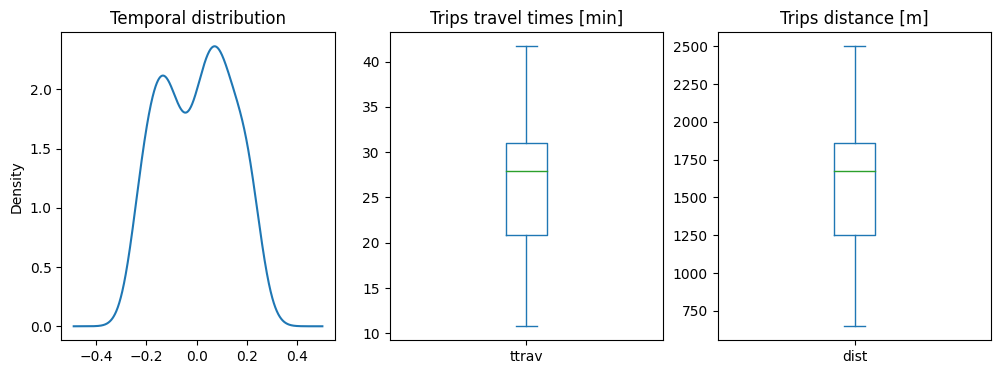

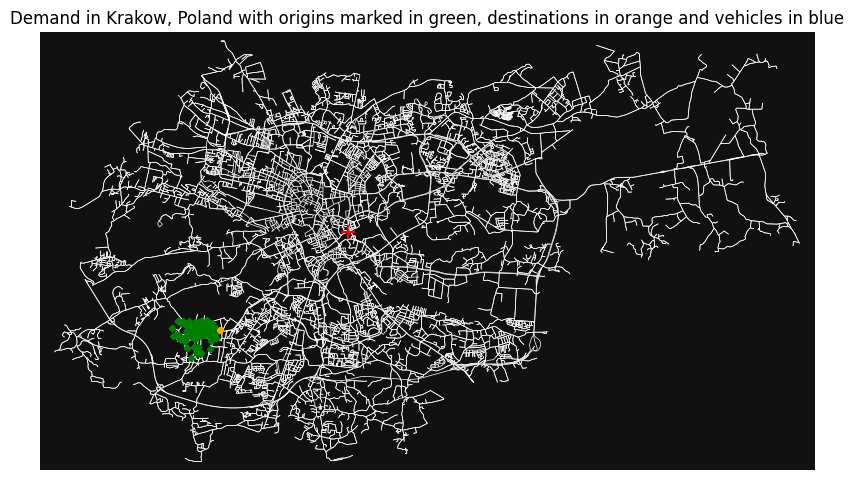

In [12]:
ExMAS.utils.plot_demand(inData, params)